Neural networks are excellent computation tools for highly non-linear problem spaces. However, when the input feature space is polluted by an overwhelming amount of 'noise' features, their performance suffers. Tree-based methods offer an efficient alternative for this special case of problem:

In [6]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import xgboost as xgb

We will first create $y$ which we will then try to model using a fully-connected feedforward neural network. Let \\
$$ y = \frac{1}{2}x_1^2 + \frac{\sqrt{5}}{2}x_2 + \frac{1}{3}x_3^3 + \epsilon $$

In [3]:
def func(X):
    return X[:,0] ** 2 / 2 + X[:,1] * np.sqrt(5) / 2 + X[:,2] ** 3 / 3 + \
    np.random.normal(scale=1e-5, size=X.shape[0])

In [4]:
X = np.random.normal(size=(50000,3))

In [5]:
y = func(X)

In [8]:
train_ix = random.sample(range(X.shape[0]), int(0.8 * X.shape[0]))
test_ix = np.setdiff1d([i for i in range(X.shape[0])], train_ix)

In [9]:
X_train = X[train_ix]
X_test = X[test_ix]
y_train = y[train_ix]
y_test = y[test_ix]

Try to model this relationship using regression:

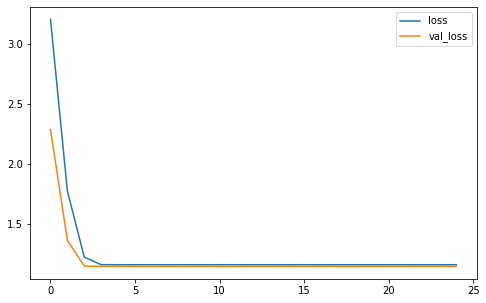

In [10]:
inputs = tf.keras.layers.Input(shape=(3,))
outputs = tf.keras.layers.Dense(1)(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="regression_model")

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop()
)

history = model.fit(X_train, 
                    y_train,
                    batch_size=64, 
                    epochs=25, 
                    validation_data=(X_test, y_test), verbose=0)

pd.DataFrame(history.history).plot(figsize=(8,5));

In [11]:
model.evaluate(X_test, y_test, verbose=0)

1.1477854251861572

Now we model the relationship using a hidden layer with non-linear activation:

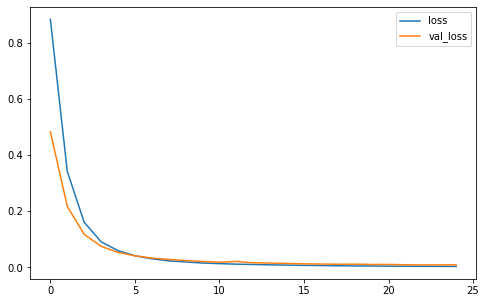

In [12]:
inputs = tf.keras.layers.Input(shape=(3,))
dense = tf.keras.layers.Dense(64, activation="relu")(inputs)
outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="shallow_dnn")

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop()
)

history = model.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    epochs=25, 
                    validation_data=(X_test, y_test), verbose=0)

pd.DataFrame(history.history).plot(figsize=(8,5));

In [13]:
model.evaluate(X_test, y_test, verbose=0)

0.009521210566163063

Now we introduce additional input features to see if the model can learn as good a representation in $\hat{y}$:

In [14]:
X_noisey = np.hstack((X, np.random.normal(size=(50000,997))))

X_train = X_noisey[train_ix]
X_test = X_noisey[test_ix]

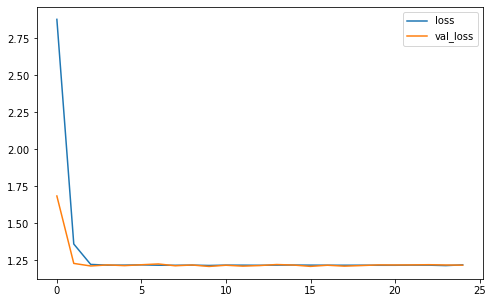

In [15]:
inputs = tf.keras.layers.Input(shape=(1000,))
outputs = tf.keras.layers.Dense(1)(inputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="shallow_dnn_noisey")

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop()
)

history = model.fit(X_train, 
                    y_train, 
                    batch_size=64, 
                    epochs=25, 
                    validation_data=(X_test, y_test), verbose=0)

pd.DataFrame(history.history).plot(figsize=(8,5));

In [16]:
model.evaluate(X_test, y_test, verbose=0)

1.2184631824493408

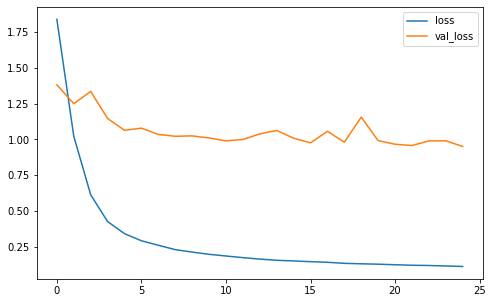

In [17]:
inputs = tf.keras.layers.Input(shape=(1000,))
dense = tf.keras.layers.Dense(1000, activation="relu")(inputs)
outputs = tf.keras.layers.Dense(1)(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="shallow_dnn_noisey")

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.RMSprop()
)

history = model.fit(X_train, y_train, batch_size=64, epochs=25, validation_data=(X_test, y_test), verbose=0)

pd.DataFrame(history.history).plot(figsize=(8,5));

In [18]:
model.evaluate(X_test, y_test, verbose=0)

0.9501705169677734

A neural network having one hidden layer with ReLU activation fails to learn the underlying mapping and overfits to the noise in the training data yielding relatively high test error.

What about XGBoost?

In [19]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [20]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'reg:squarederror',  
    } 

steps = 25  # The number of training iterations

In [21]:
model = xgb.train(param, D_train, steps)

In [22]:
preds = model.predict(D_test)

In [23]:
np.mean((preds - y_test) ** 2)

0.0777052794428191

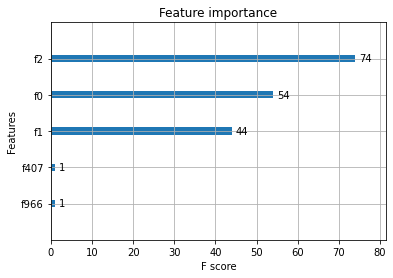

In [24]:
xgb.plot_importance(model);

The boosting model identified only five features out of 1000; the overwhelmingly higher-ranking features are the 'true' features. 